<a href="https://colab.research.google.com/github/rimosoma/ML_for_healt/blob/main/lab5healt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as sk
from sklearn.preprocessing import MinMaxScaler


#--------------------------------------------------------------------------------------------------------------
# DATA READING AND PREPARATION
#--------------------------------------------------------------------------------------------------------------

#%%
plt.close('all')
xx=pd.read_csv("covid_serological_results.csv")
xx=xx[xx.COVID_swab_res!=1]# remove unclear results
#xx.COVID_swab_res[xx.COVID_swab_res==2]=1# set swab result from 2 to 1 for ill patients
xx.loc[xx.COVID_swab_res==2,"COVID_swab_res"]=1

ALL_INFO_FLAG = False

#%%
swab=xx.COVID_swab_res.values# results from swab: 0= no illness, 1=illness
Test1=xx.IgG_Test1_titre.values
Test2=xx.IgG_Test2_titre.values

In [7]:
# START
#--------------------------------------------------------------------------------------------------------------
# Sections :
# 0. Data Analysis (EDA)
# 1. Outlier Removal (DBSCAN)
# 2. Sensitivity/Specificity Analysis
# 3. ROC and AUC
# 4. Comparison


print("---------------------------------------")
print("---------------------------------------")
print("--- 🏁​🏁​START OF STUDENT ANALYSIS ⬇️⬇️⬇️⬇️⬇️⬇️⬇️")

# 0. DATA ANALYSIS (EDA)
# The PDF asks to: "Perform the usual data analysis using xx.describe(),
# pd.plotting.scatter_matrix(), etc."
if ALL_INFO_FLAG:

    print('✅ALL_INFO_FLAG: ON; ⬇️⬇️⬇️⬇️⬇️⬇️⬇️')
    print("\n--- 0. DATA EXPLORATION ---")
    print("Descriptive Statistics (xx.describe()):")
    # Generates statistics (mean, std, min, max) for the dataset
    print(xx.describe())

    print("Generating Scatter Matrix plot...")
    # Visualizes correlations and distributions of the features
    pd.plotting.scatter_matrix(xx[['IgG_Test1_titre', 'IgG_Test2_titre', 'COVID_swab_res']],
                               figsize=(10, 8),
                               diagonal='kde',
                               alpha=0.6)
    plt.suptitle("Scatter Matrix (Original Data)")
    plt.show()

else:
    print("---------------------------------------")
    print("---------------------------------------")
    print('❗ALL_INFO_FLAG: OFF')


---------------------------------------
---------------------------------------
--- 🏁​🏁​START OF STUDENT ANALYSIS ⬇️⬇️⬇️⬇️⬇️⬇️⬇️
---------------------------------------
---------------------------------------
❗ALL_INFO_FLAG: OFF


In [8]:
# # 1. OUTLIER REMOVAL (As requested in 'Data Analysis' section of PDF)
#  We look for anomalies where healthy patients have unexpectedly high IgG.
# We use DBSCAN on normalized data.

print("\n--- 1. 🫆​🫆​OUTLIER DETECTION (DBSCAN) ---")

# Normalize data (0-1 range) for DBSCAN
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(xx[['IgG_Test1_titre', 'IgG_Test2_titre']])

# Apply DBSCAN (using 'sk' alias defined in initial code)
# eps=0.05, min_samples=5 are standard starting points for this density
dbscan = sk.DBSCAN(eps=0.05, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Identify outliers (cluster -1)
outlier_mask = clusters == -1
print(f"Number of outliers detected and removed: {np.sum(outlier_mask)}")

# Remove outliers from the main dataframe 'xx', I clean the dataset definately
xx_clean = xx[~outlier_mask]

# RE-DEFINE ARRAYS AFTER CLEANING
# We must update our arrays because rows were dropped
#extract the values of the features that i want from the cleaned db
swab_clean = xx_clean.COVID_swab_res.values
Test1_clean = xx_clean.IgG_Test1_titre.values
Test2_clean = xx_clean.IgG_Test2_titre.values


--- 1. 🫆​🫆​OUTLIER DETECTION (DBSCAN) ---
Number of outliers detected and removed: 33


In [12]:
import matplotlib.pyplot as plt

# Imposta la famiglia generica 'serif'
plt.rcParams['font.family'] = 'serif'

# Imposta Liberation Serif come prima scelta.
# Se non lo trova, userà DejaVu Serif (molto simile)
plt.rcParams['font.serif'] = ['Liberation Serif', 'DejaVu Serif']

print("✅ Font Serif impostato (Liberation Serif/DejaVu Serif)")

✅ Font Serif impostato (Liberation Serif/DejaVu Serif)



--- 2. 💉​🩸​ANALYZING TEST 2 ---


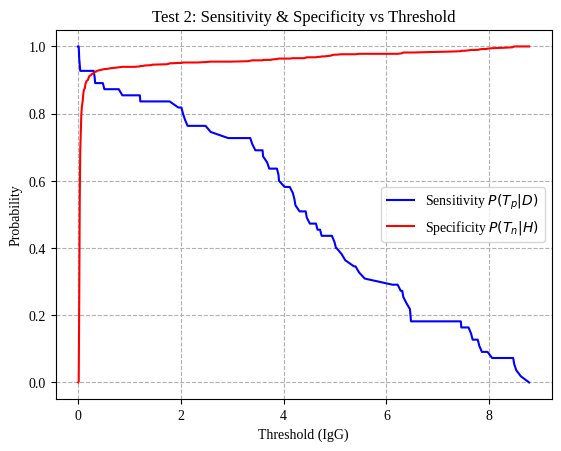

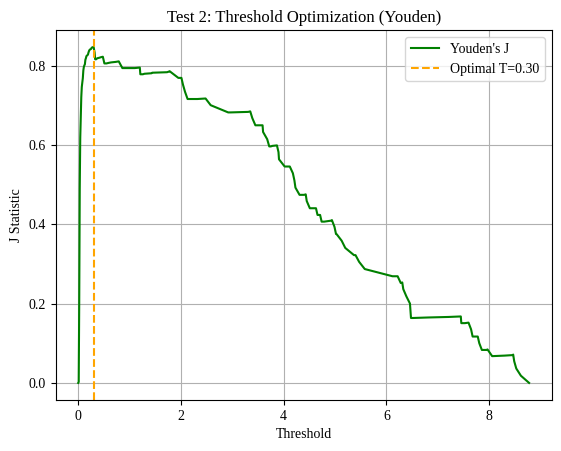

Optimal Threshold for Test 2: 0.3000


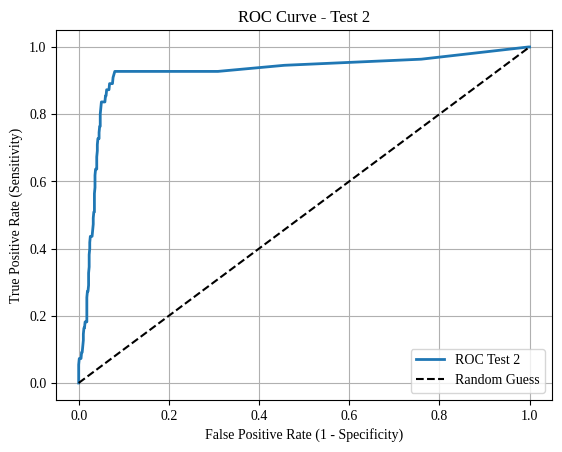

Area Under Curve (AUC) for Test 2: 0.9215


In [13]:
# # 2. ANALYSIS FOR TEST 2 (

test_name = "Test 2"
test_values = Test2_clean
ground_truth = swab_clean
print("\n--- 2. 💉​🩸​ANALYZING TEST 2 ---")

# Define thresholds: sorted unique values + 0
thresholds = np.sort(np.unique(test_values))
thresholds = np.insert(thresholds, 0, 0)

# --- Calculate Sensitivity and Specificity ---
sens_list = []
spec_list = []

# Filter based on ground truth
vals_ill = test_values[ground_truth == 1]
vals_healthy = test_values[ground_truth == 0]

N_ill = len(vals_ill)
N_healthy = len(vals_healthy)
#print("GROUND TRUTH")
#print(f"over {N_ill + N_healthy} patients, {N_ill} are ill and {N_healthy} are healthy")

for t in thresholds:
    # True Positives: Ill patients with value > t
    tp = np.sum(vals_ill > t)
    # True Negatives: Healthy patients with value < t
    tn = np.sum(vals_healthy < t)

    sens_list.append(tp / N_ill if N_ill > 0 else 0)
    spec_list.append(tn / N_healthy if N_healthy > 0 else 0)


sens = np.array(sens_list)
spec = np.array(spec_list)
# -----------------------------------------------------

fpr = 1 - spec # False Positive Rate

# --- PLOT A: Sensitivity and Specificity vs Threshold ---
plt.figure()
plt.plot(thresholds, sens, label='Sensitivity $P(T_p|D)$', color='blue')
plt.plot(thresholds, spec, label='Specificity $P(T_n|H)$', color='red')
plt.title(f'{test_name}: Sensitivity & Specificity vs Threshold')
plt.xlabel('Threshold (IgG)')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# --- PLOT B: Youden's Index (Threshold Optimization) ---
# Youden's J = Sensitivity + Specificity - 1
# We want to maximize J to find the optimal cut-off
J = sens + spec - 1
best_idx = np.argmax(J)
best_thresh = thresholds[best_idx]

plt.figure()
plt.plot(thresholds, J, label="Youden's J", color='green')
plt.axvline(best_thresh, color='orange', linestyle='--', label=f'Optimal T={best_thresh:.2f}')
plt.title(f'{test_name}: Threshold Optimization (Youden)')
plt.xlabel('Threshold')
plt.ylabel('J Statistic')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Threshold for {test_name}: {best_thresh:.4f}")

# --- PLOT C: ROC Curve ---
# We plot Sensitivity (y) vs 1-Specificity (x)
plt.figure()
plt.plot(fpr, sens, linewidth=2, label=f'ROC {test_name}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title(f'ROC Curve - {test_name}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend()
plt.show()

# Calculate AUC
# Use trapezoidal rule. Note: Need to sort by x-axis (FPR)

#  THE PROBLEM: Our ROC curve is not a continuous line defined by a formula.
#    It is just a collection of separate dots (discrete points) derived
#    from our thresholds.
#
#  THE SOLUTION (Trapezoidal Rule):
#    - Since we can't do a mathematical integral, we approximate the area.
#    - Imagine connecting each dot to the next one with a straight line.
#    - This creates a series of "trapezoids" under the curve.
#    - This function sums up the area of all these small trapezoids to
#      give us the total Area Under the Curve.
sort_idx = np.argsort(fpr)
auc_val = np.trapezoid(sens[sort_idx], fpr[sort_idx])
print(f"Area Under Curve (AUC) for {test_name}: {auc_val:.4f}")

# STORE RESULTS FOR TEST 2 COMPARISON
fpr2, tpr2, auc2 = fpr, sens, auc_val


--- 2. 💉​🩸​ANALYZING TEST 1 ---


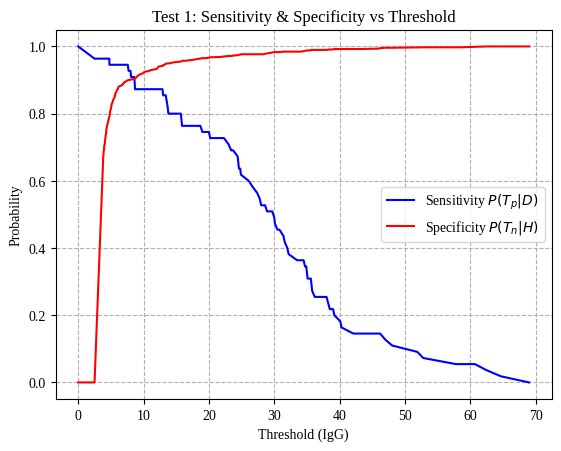

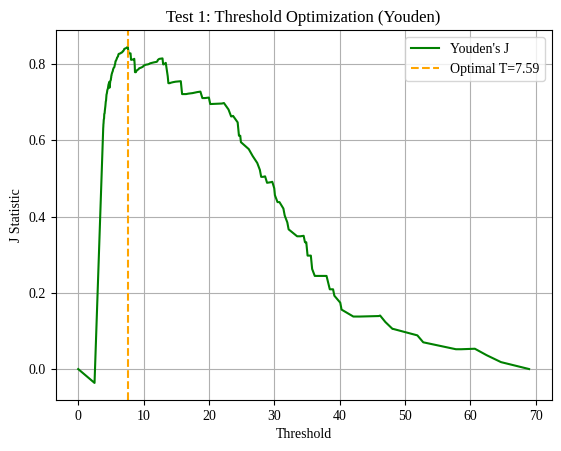

Optimal Threshold for Test 1: 7.5900


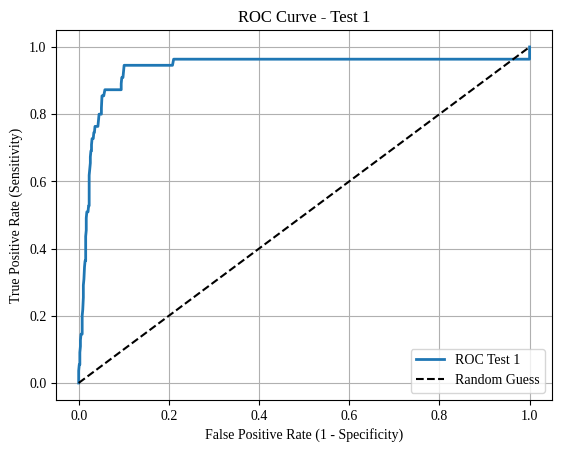

Area Under Curve (AUC) for Test 1: 0.9358


In [14]:

# =============================================================================
# 3. ANALYSIS FOR TEST 1 (Monolithic - Logic Inlined)
# =============================================================================
test_name = "Test 1"
test_values = Test1_clean
ground_truth = swab_clean

print("\n--- 2. 💉​🩸​ANALYZING TEST 1 ---")

# Define thresholds: sorted unique values + 0
thresholds = np.sort(np.unique(test_values))
thresholds = np.insert(thresholds, 0, 0)

# --- INLINED Calculate Sensitivity and Specificity ---
sens_list = []
spec_list = []

# Filter based on ground truth
vals_ill = test_values[ground_truth == 1]
vals_healthy = test_values[ground_truth == 0]

N_ill = len(vals_ill)
N_healthy = len(vals_healthy)

for t in thresholds:
    # True Positives: Ill patients with value > t
    tp = np.sum(vals_ill > t)
    # True Negatives: Healthy patients with value < t
    tn = np.sum(vals_healthy < t)

    sens_list.append(tp / N_ill if N_ill > 0 else 0)
    spec_list.append(tn / N_healthy if N_healthy > 0 else 0)

sens = np.array(sens_list)
spec = np.array(spec_list)
# -----------------------------------------------------

fpr = 1 - spec # False Positive Rate

# --- PLOT A: Sensitivity and Specificity vs Threshold ---
plt.figure()
plt.plot(thresholds, sens, label='Sensitivity $P(T_p|D)$', color='blue')
plt.plot(thresholds, spec, label='Specificity $P(T_n|H)$', color='red')
plt.title(f'{test_name}: Sensitivity & Specificity vs Threshold')
plt.xlabel('Threshold (IgG)')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# --- PLOT B: Youden's Index (Threshold Optimization) ---
# Youden's J = Sensitivity + Specificity - 1
# We want to maximize J to find the optimal cut-off
J = sens + spec - 1
best_idx = np.argmax(J)
best_thresh = thresholds[best_idx]

plt.figure()
plt.plot(thresholds, J, label="Youden's J", color='green')
plt.axvline(best_thresh, color='orange', linestyle='--', label=f'Optimal T={best_thresh:.2f}')
plt.title(f'{test_name}: Threshold Optimization (Youden)')
plt.xlabel('Threshold')
plt.ylabel('J Statistic')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Threshold for {test_name}: {best_thresh:.4f}")

# --- PLOT C: ROC Curve ---
# We plot Sensitivity (y) vs 1-Specificity (x)
plt.figure()
plt.plot(fpr, sens, linewidth=2, label=f'ROC {test_name}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title(f'ROC Curve - {test_name}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend()
plt.show()

# Calculate AUC
# Use trapezoidal rule. Note: Need to sort by x-axis (FPR) for integration
sort_idx = np.argsort(fpr)
auc_val = np.trapezoid(sens[sort_idx], fpr[sort_idx])
print(f"Area Under Curve (AUC) for {test_name}: {auc_val:.4f}")

# STORE RESULTS FOR TEST 1 COMPARISON
fpr1, tpr1, auc1 = fpr, sens, auc_val





--- 🆚COMPARISON🆚---


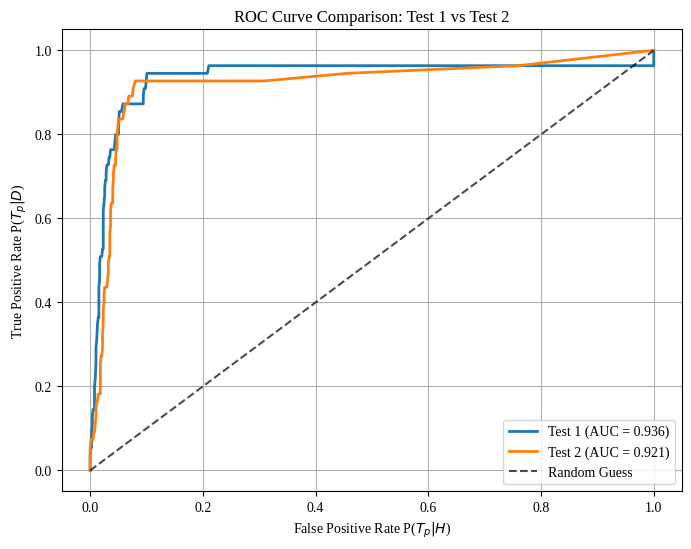

Conclusion: Test 1 performs better based on AUC.


In [15]:

# =============================================================================
# 4. COMPARISON PLOT
# =============================================================================
print("\n--- 🆚COMPARISON🆚---")
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Test 1 (AUC = {auc1:.3f})', linewidth=2)
plt.plot(fpr2, tpr2, label=f'Test 2 (AUC = {auc2:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Random Guess')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate P($T_p|H$)')
plt.ylabel('True Positive Rate P($T_p|D$)')
plt.title('ROC Curve Comparison: Test 1 vs Test 2')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

if auc1 > auc2:
    print("Conclusion: Test 1 performs better based on AUC.")
else:
    print("Conclusion: Test 2 performs better based on AUC.")